In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from openpyxl import load_workbook
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense
from keras.layers import GRU
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [37]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    #print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    #print(out.to_string())         
    
    if result[1] <= 0.05:
        return "Stationary"
    else:
        return "Non-Stationary"

In [107]:
df = pd.read_excel("/kaggle/input/fyp-dataset/Dataset_Fyp.xlsx", sheet_name='Version5.1',engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
columns = list(df.columns)
df.head()

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee
Date,,,,,,,,,,,
2020-02-14,822.057953,2873,-3909.338048,-717.286214,9144,2183.962961,3448.222619,91,4175,8.66,71.45
2020-02-15,820.730165,2873,-3900.894823,-733.501969,9144,2177.611519,3435.571668,91,4175,8.66,71.45
2020-02-16,819.402376,2873,-3892.451599,-749.717725,9144,2171.260077,3422.920718,91,4175,8.66,71.45
2020-02-17,818.074588,2873,-3884.008375,-765.933480,9144,2164.908635,3410.269767,91,4175,8.66,71.38
2020-02-18,816.746799,2873,-3875.565150,-782.149235,9144,2158.557192,3397.618816,91,4175,8.66,71.55


Non-Stationary
Stationary


<AxesSubplot:xlabel='Date'>

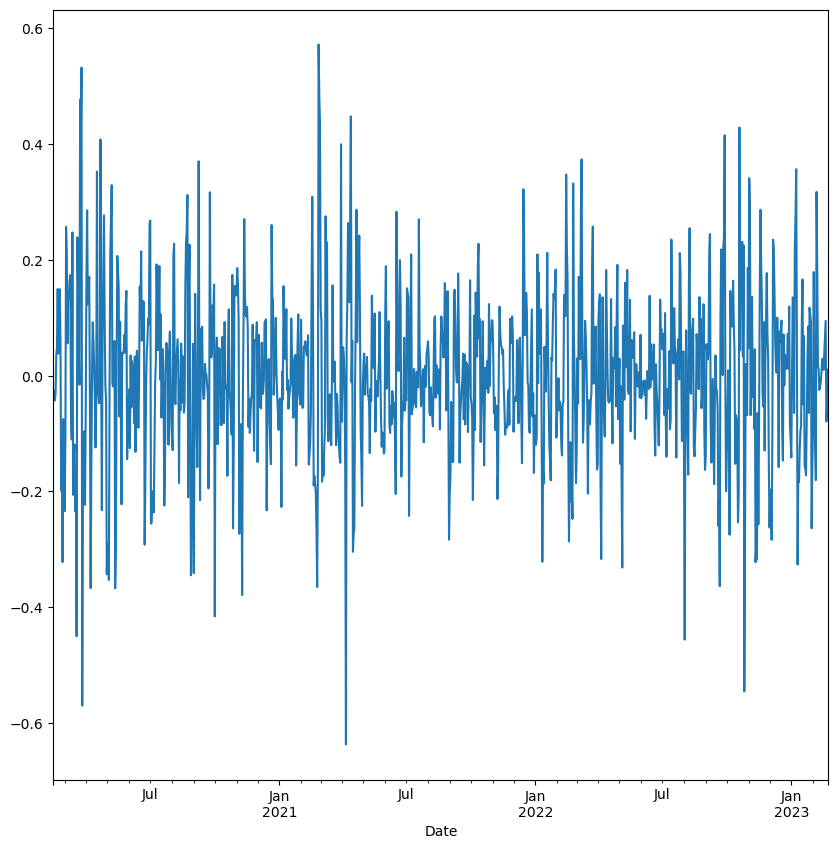

In [108]:
from statsmodels.tsa.seasonal import STL
print(adf_test(df['Value of Rupee']))
stl = STL(df['Value of Rupee'], period=7)
res = stl.fit()
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['residual'] = res.resid
#df['reversed'] = df['residual']+df['trend']+df['seasonal']
print(adf_test(df['residual']))
df['residual'].plot(figsize=(10,10))

In [30]:
df['Predicted'] = df['trend']+df['seasonal']+df['residual'] 

In [5]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train = df_scaled.iloc[:train_size, :]
test = df_scaled.iloc[train_size:, :]

# Define generator for train data
n_input = 7 # number of input steps
n_features = len(df.columns) # number of features
train_generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=1)


In [79]:
# Define generator for train data
n_input = 7 # number of input steps
n_features = len(df.columns) # number of features
train_generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=1)

# Define LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('models.h5', 
                             monitor='mse', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
# Train model
history = model.fit(train_generator, epochs=50,verbose=1,callbacks=[checkpoint])

# Define generator for test data
test_generator = TimeseriesGenerator(test.values, test.values, length=n_input, batch_size=1)

Epoch 1/50
767/767 [==============================] - 13s 15ms/step - loss: 0.0162
Epoch 2/50
767/767 [==============================] - 11s 15ms/step - loss: 0.0083
Epoch 3/50
767/767 [==============================] - 12s 15ms/step - loss: 0.0070
Epoch 4/50
767/767 [==============================] - 11s 15ms/step - loss: 0.0062
Epoch 5/50
767/767 [==============================] - 12s 15ms/step - loss: 0.0052
Epoch 6/50
767/767 [==============================] - 11s 15ms/step - loss: 0.0047
Epoch 7/50
767/767 [==============================] - 11s 15ms/step - loss: 0.0044
Epoch 8/50
 68/767 [=>............................] - ETA: 11s - loss: 0.0036

KeyboardInterrupt: 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               172000    
                                                                 
 dense (Dense)               (None, 14)                2814      
                                                                 
Total params: 174,814
Trainable params: 174,814
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 18ms/step


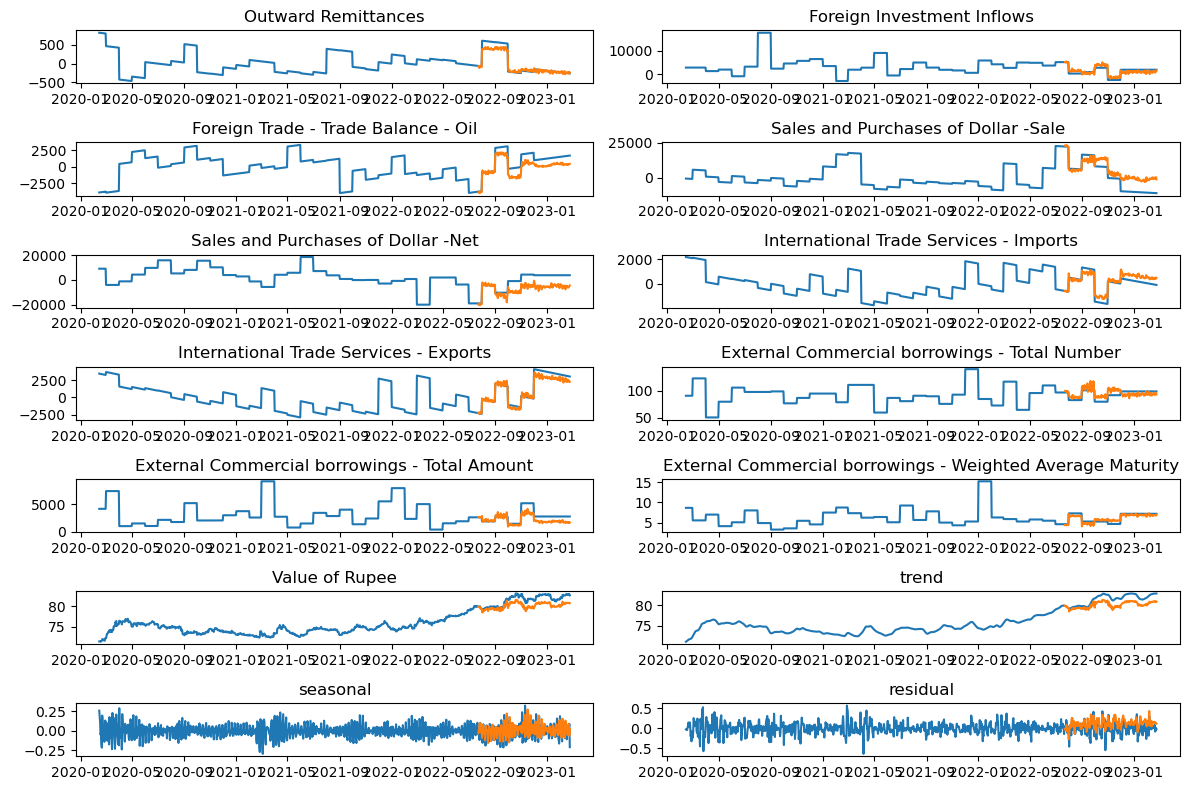

In [11]:
# Define generator for test data
test_generator = TimeseriesGenerator(test.values, test.values, length=n_input, batch_size=1)

# Make predictions
predictions = []
for i in range(len(test) - n_input + 1):
    x_test = test.iloc[i:i+n_input, :]
    x_test = np.expand_dims(x_test, axis=0)
    pred = model.predict(x_test)[0]
    predictions.append(pred)

# Convert predictions to DataFrame
predictions = scaler.inverse_transform(predictions)
index = test.iloc[n_input-1:].index
columns = df.columns
predictions_df = pd.DataFrame(predictions, index=index, columns=columns)


# Plot results
n_cols = 2
n_rows = (predictions_df.shape[1] + n_cols - 1) // n_cols
    
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

axs = axs.flatten()

for i, column in enumerate(predictions_df.columns):
    axs[i].plot(df.index, df[column], label='actual')
    axs[i].plot(predictions_df.index, predictions_df[column], label='predicted')
    axs[i].set_title(column)
    

for i in range(predictions_df.shape[1], n_rows*n_cols):
    fig.delaxes(axs[i])    

plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Prediction on test data'}, xlabel='Date'>

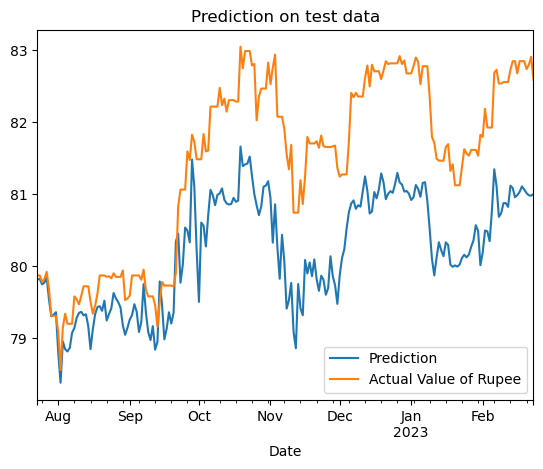

In [36]:
predictions_df['Prediction'] = predictions_df['trend']+predictions_df['seasonal']+predictions_df['residual']
values = predictions_df[['Prediction']]
values['Actual Value of Rupee'] = df.loc['2022-07-23':,'Value of Rupee']
values.plot(title = 'Prediction on test data')

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
mape = np.mean(np.abs((values['Actual Value of Rupee'] - values['Prediction']) /values['Actual Value of Rupee']))*100
mse = mean_squared_error(values['Actual Value of Rupee'], values['Prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(values['Actual Value of Rupee'],values['Prediction'])

results = pd.DataFrame()

columns = ['MAPE','MSE','RMSE','MAE']
val = [mape,mse,rmse,mae]

results['Metrics'] = columns
results['Values'] = val

results

,Metrics,Values
0,MAPE,1.457649
1,MSE,1.800385
2,RMSE,1.341784
3,MAE,1.194441


In [109]:
from keras.models import load_model
model = load_model('/kaggle/input/links-h5/lstm.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               172000    
                                                                 
 dense (Dense)               (None, 14)                2814      
                                                                 
Total params: 174,814
Trainable params: 174,814
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                15360     
                                                                 
 dense_2 (Dense)             (None, 14)                910       
                                                                 
Total params: 16,270
Trainable params: 16,270
Non-trainable params: 0
_________________________________________________________________


1106
1099/1099 [==============================] - 3s 3ms/step
1099
1099


<AxesSubplot:title={'center':'Prediction on the complete dataset'}, xlabel='Date'>

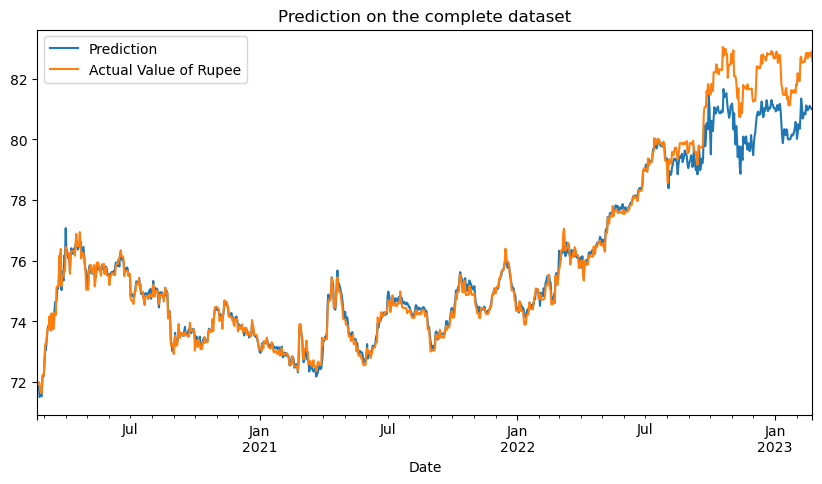

In [38]:
data = pd.concat([train, test], axis=0)
print(len(data))
data_gen = TimeseriesGenerator(data.values, data.values, length=n_input, batch_size=1, shuffle=False)
data_pred = model.predict(data_gen)
data_pred = scaler.inverse_transform(data_pred)
print(len(data_pred))
index = data.iloc[n_input:].index
print(len(index))
columns = df.columns
predictions_df = pd.DataFrame(data_pred, index=index, columns=columns)
predictions_df['Prediction'] = predictions_df['trend']+predictions_df['seasonal']+predictions_df['residual']
values = predictions_df[['Prediction']]
values['Actual Value of Rupee'] = df.iloc[:,-4]
values.plot(figsize = (10,5),title='Prediction on the complete dataset')

<h2> GRU </h2>

In [14]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train = df_scaled.iloc[:train_size, :]
test = df_scaled.iloc[train_size:, :]

# Define generator for train data
n_input = 7 # number of input steps
n_features = len(df.columns) # number of features
train_generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(test.values, test.values, length=n_input, batch_size=1)

In [15]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('models.h5', 
                             monitor='mse', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
# Train model
history = model.fit(train_generator, epochs=50,verbose=1,callbacks=[checkpoint])

Epoch 1/50
877/877 [==============================] - 18s 19ms/step - loss: 0.0206
Epoch 2/50
877/877 [==============================] - 16s 18ms/step - loss: 0.0061
Epoch 3/50
877/877 [==============================] - 17s 19ms/step - loss: 0.0051
Epoch 4/50
877/877 [==============================] - 16s 18ms/step - loss: 0.0048
Epoch 5/50
877/877 [==============================] - 16s 18ms/step - loss: 0.0045
Epoch 6/50
877/877 [==============================] - 17s 19ms/step - loss: 0.0043
Epoch 7/50
877/877 [==============================] - 16s 18ms/step - loss: 0.0041
Epoch 8/50
877/877 [==============================] - 17s 19ms/step - loss: 0.0038
Epoch 9/50
877/877 [==============================] - 16s 18ms/step - loss: 0.0037
Epoch 10/50
877/877 [==============================] - 17s 19ms/step - loss: 0.0036
Epoch 11/50
877/877 [==============================] - 16s 19ms/step - loss: 0.0036
Epoch 12/50
877/877 [==============================] - 17s 19ms/step - loss: 0.0035
E

1/1 [==============================] - 0s 18ms/step


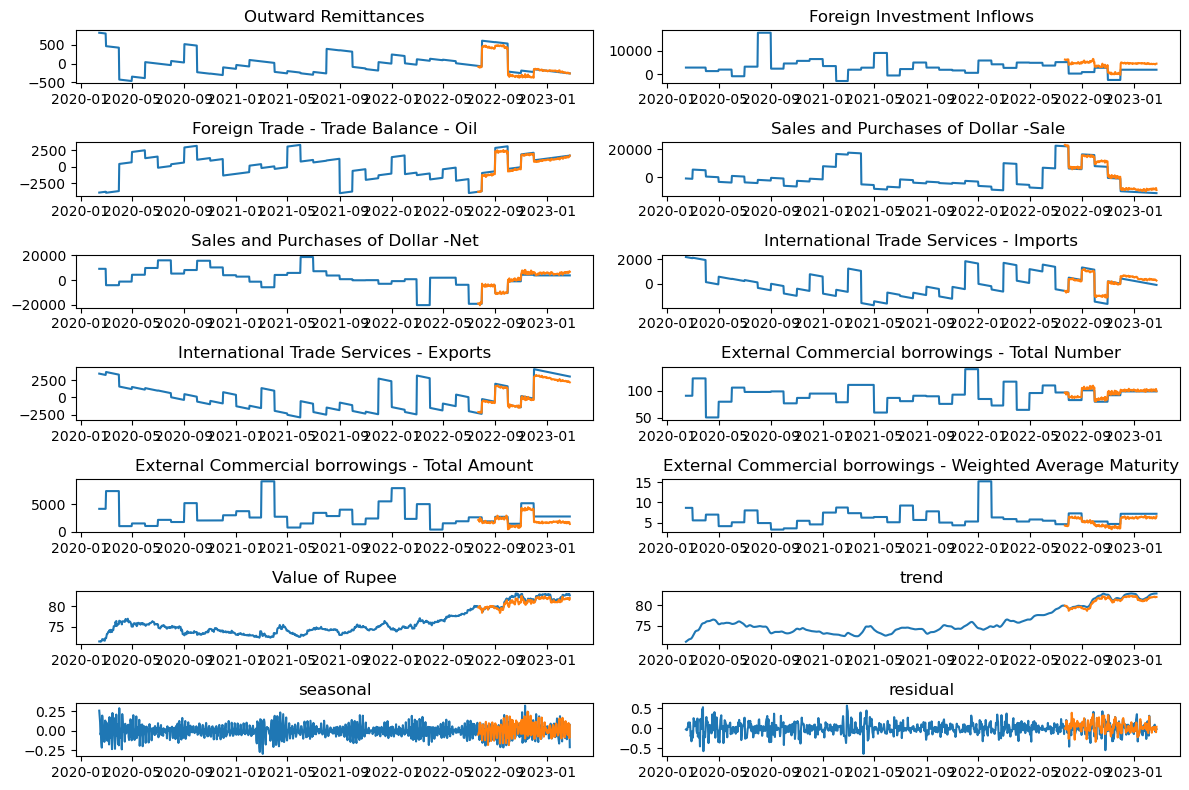

In [24]:

# Make predictions
predictions = []
for i in range(len(test) - n_input + 1):
    x_test = test.iloc[i:i+n_input, :]
    x_test = np.expand_dims(x_test, axis=0)
    pred = model.predict(x_test)[0]
    predictions.append(pred)

# Convert predictions to DataFrame
predictions = scaler.inverse_transform(predictions)
index = test.iloc[n_input-1:].index
columns = df.columns
predictions_df = pd.DataFrame(predictions, index=index, columns=columns)

n_cols = 2
n_rows = (predictions_df.shape[1] + n_cols - 1) // n_cols
    
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

axs = axs.flatten()

for i, column in enumerate(predictions_df.columns):
    axs[i].plot(df.index, df[column], label='actual')
    axs[i].plot(predictions_df.index, predictions_df[column], label='predicted')
    axs[i].set_title(column)
    

for i in range(predictions_df.shape[1], n_rows*n_cols):
    fig.delaxes(axs[i])    

plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Prediction on test data'}, xlabel='Date'>

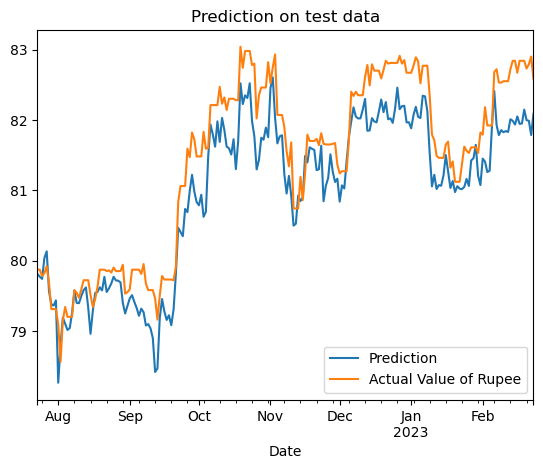

In [25]:
predictions_df['Prediction'] = predictions_df['trend']+predictions_df['seasonal']+predictions_df['residual']
values = predictions_df[['Prediction']]
values['Actual Value of Rupee'] = df.loc['2022-07-23':,'Value of Rupee']
values.plot(title = 'Prediction on test data')

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
mape = np.mean(np.abs((values['Actual Value of Rupee'] - values['Prediction']) /values['Actual Value of Rupee']))*100
mse = mean_squared_error(values['Actual Value of Rupee'], values['Prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(values['Actual Value of Rupee'],values['Prediction'])

results = pd.DataFrame()

columns = ['MAPE','MSE','RMSE','MAE']
val = [mape,mse,rmse,mae]

results['Metrics'] = columns
results['Values'] = val

results

,Metrics,Values
0,MAPE,0.559328
1,MSE,0.284590
2,RMSE,0.533470
3,MAE,0.457345


1106
1099/1099 [==============================] - 3s 3ms/step
1099
1099


<AxesSubplot:title={'center':'Prediction on the complete dataset'}, xlabel='Date'>

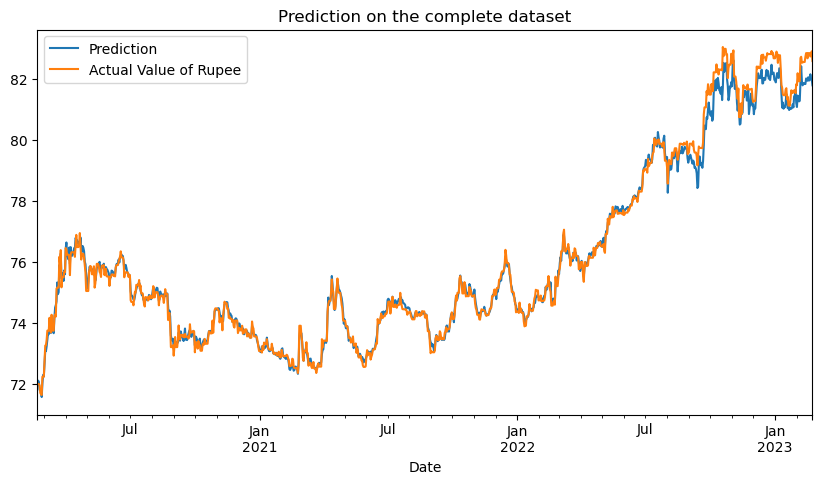

In [29]:
data = pd.concat([train, test], axis=0)
print(len(data))
data_gen = TimeseriesGenerator(data.values, data.values, length=n_input, batch_size=1, shuffle=False)
data_pred = model.predict(data_gen)
data_pred = scaler.inverse_transform(data_pred)
print(len(data_pred))
index = data.iloc[n_input:].index
print(len(index))
columns = df.columns
predictions_df = pd.DataFrame(data_pred, index=index, columns=columns)
predictions_df['Prediction'] = predictions_df['trend']+predictions_df['seasonal']+predictions_df['residual']
values = predictions_df[['Prediction']]
values['Actual Value of Rupee'] = df.iloc[:,-4]
values.plot(figsize = (10,5),title='Prediction on the complete dataset')

In [6]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


# Define generator for train data
n_input = 7 # number of input steps
n_features = len(df.columns) # number of features
total_generator = TimeseriesGenerator(df_scaled.values, df_scaled.values, length=n_input, batch_size=1)

In [110]:
n_forecast = 12  # the number of timesteps to forecast
forecast = []
batch = df_scaled.values[-n_input:].reshape((1, n_input, n_features))
for i in range(n_forecast):
    pred = model.predict(batch)[0]
    forecast.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred]], axis=1)

1/1 [==============================] - 0s 22ms/step


In [111]:
forecast = scaler.inverse_transform(forecast)
# Convert the forecast into a DataFrame and set the index
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=n_forecast, freq='MS'), columns=df.columns)
forecast_df = forecast_df.resample('D').fillna(method='ffill').fillna(method='bfill')
forecast_df['Prediction'] = forecast_df['trend']+forecast_df['seasonal']+forecast_df['residual']
forecast_df

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee,trend,seasonal,residual,Prediction
2023-03-01,-249.385511,1679.228140,444.999026,-1282.246628,-4455.388611,476.299437,2273.216956,93.511889,1658.370612,6.980476,80.703884,80.853143,0.023076,0.121661,80.997879
2023-03-02,-249.385511,1679.228140,444.999026,-1282.246628,-4455.388611,476.299437,2273.216956,93.511889,1658.370612,6.980476,80.703884,80.853143,0.023076,0.121661,80.997879
2023-03-03,-249.385511,1679.228140,444.999026,-1282.246628,-4455.388611,476.299437,2273.216956,93.511889,1658.370612,6.980476,80.703884,80.853143,0.023076,0.121661,80.997879
2023-03-04,-249.385511,1679.228140,444.999026,-1282.246628,-4455.388611,476.299437,2273.216956,93.511889,1658.370612,6.980476,80.703884,80.853143,0.023076,0.121661,80.997879
2023-03-05,-249.385511,1679.228140,444.999026,-1282.246628,-4455.388611,476.299437,2273.216956,93.511889,1658.370612,6.980476,80.703884,80.853143,0.023076,0.121661,80.997879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-28,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-29,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-30,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-31,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475


In [88]:
forecast_df

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee,trend,seasonal,residual,Prediction
2023-02-23,-264.730241,4559.041577,1698.167752,-8932.453686,6730.317639,245.604526,2191.646027,99.539721,1383.436801,6.596681,81.899486,81.971425,0.073643,0.042072,82.087140
2023-02-24,-259.437586,6846.392733,1282.996082,-7748.297142,7605.311059,585.959594,1712.847342,100.830780,768.287309,5.569985,81.225127,81.499835,0.027334,-0.081056,81.446112
2023-02-25,-282.920447,9161.749845,995.696868,-7337.506469,8531.828323,810.841849,1314.894780,100.836457,135.061147,4.767555,80.785831,81.201723,-0.008241,-0.133390,81.060092
2023-02-26,-277.577854,11503.593630,777.532627,-5551.393573,7678.553092,889.990056,1027.481681,101.251765,-164.410561,4.327504,80.834320,81.017094,0.048531,-0.006771,81.058855
2023-02-27,-260.580316,13919.628948,533.371823,-3172.535245,6379.197307,946.044363,804.071382,102.157169,-331.872985,3.976170,80.732555,80.916955,0.067057,0.036402,81.020413
2023-02-28,-243.425992,16375.471318,227.763764,-817.599443,4679.926259,1018.466062,637.147707,103.065491,-474.094006,3.626274,80.580127,80.762130,0.095094,0.052100,80.909324
2023-03-01,-214.282207,18870.635065,52.230941,2147.123696,4365.286111,1095.772600,529.896308,107.706704,-523.278460,3.281263,79.829350,80.647208,-0.154682,-0.138170,80.354356


In [112]:
df['Prediction'] = df['trend']+df['seasonal']+df['residual']
#df.drop('Predicted',axis=1,inplace=True)
df

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee,trend,seasonal,residual,Prediction
Date,,,,,,,,,,,,,,,
2020-02-14,822.057953,2873,-3909.338048,-717.286214,9144,2183.962961,3448.222619,91,4175,8.66,71.45,71.216559,0.259145,-0.025704,71.45
2020-02-15,820.730165,2873,-3900.894823,-733.501969,9144,2177.611519,3435.571668,91,4175,8.66,71.45,71.299619,0.185469,-0.035088,71.45
2020-02-16,819.402376,2873,-3892.451599,-749.717725,9144,2171.260077,3422.920718,91,4175,8.66,71.45,71.380824,0.111898,-0.042723,71.45
2020-02-17,818.074588,2873,-3884.008375,-765.933480,9144,2164.908635,3410.269767,91,4175,8.66,71.38,71.459846,-0.049044,-0.030803,71.38
2020-02-18,816.746799,2873,-3875.565150,-782.149235,9144,2158.557192,3397.618816,91,4175,8.66,71.55,71.536528,-0.022522,0.035995,71.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-19,-258.277206,1954,1657.651950,-11055.832682,3842,-87.974914,3081.525849,99,2768,7.20,82.84,82.786893,-0.041728,0.094835,82.84
2023-02-20,-259.604994,1954,1666.095174,-11072.048437,3842,-94.326356,3068.874899,99,2768,7.20,82.73,82.792834,0.016107,-0.078941,82.73
2023-02-21,-260.932783,1954,1674.538398,-11088.264192,3842,-100.677798,3056.223948,99,2768,7.20,82.79,82.797582,0.045961,-0.053543,82.79


In [80]:
forecast_df

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee,trend,seasonal,residual,Prediction
2023-02-23,-264.730241,4559.041577,1698.167752,-8932.453686,6730.317639,245.604526,2191.646027,99.539721,1383.436801,6.596681,81.899486,81.971425,0.073643,0.042072,82.087140
2023-02-24,-259.437586,6846.392733,1282.996082,-7748.297142,7605.311059,585.959594,1712.847342,100.830780,768.287309,5.569985,81.225127,81.499835,0.027334,-0.081056,81.446112
2023-02-25,-282.920447,9161.749845,995.696868,-7337.506469,8531.828323,810.841849,1314.894780,100.836457,135.061147,4.767555,80.785831,81.201723,-0.008241,-0.133390,81.060092
2023-02-26,-277.577854,11503.593630,777.532627,-5551.393573,7678.553092,889.990056,1027.481681,101.251765,-164.410561,4.327504,80.834320,81.017094,0.048531,-0.006771,81.058855
2023-02-27,-260.580316,13919.628948,533.371823,-3172.535245,6379.197307,946.044363,804.071382,102.157169,-331.872985,3.976170,80.732555,80.916955,0.067057,0.036402,81.020413
2023-02-28,-243.425992,16375.471318,227.763764,-817.599443,4679.926259,1018.466062,637.147707,103.065491,-474.094006,3.626274,80.580127,80.762130,0.095094,0.052100,80.909324
2023-03-01,-214.282207,18870.635065,52.230941,2147.123696,4365.286111,1095.772600,529.896308,107.706704,-523.278460,3.281263,79.829350,80.647208,-0.154682,-0.138170,80.354356
2023-03-02,-219.237561,21163.892624,27.611061,4504.335160,2824.947783,1230.000418,424.665501,106.552144,-805.618115,2.975295,80.141997,80.208666,0.139250,0.049001,80.396917
2023-03-03,-204.492995,23407.534666,161.991594,7204.045867,1860.251111,1244.839361,464.754885,110.711796,-568.982530,2.496507,79.973345,80.147317,0.071949,0.107805,80.327071
2023-03-04,-216.775599,25217.032920,424.774245,9456.270091,1046.579771,1297.529230,540.961371,113.021661,-539.330073,1.902620,79.826399,79.989975,0.040830,0.144635,80.175440


In [113]:
forecast_df.index.name = 'date'
complete_df = pd.concat([df, forecast_df])
complete_df = complete_df.fillna(method='ffill').fillna(method='bfill')
complete_df

,Outward Remittances,Foreign Investment Inflows,Foreign Trade - Trade Balance - Oil,Sales and Purchases of Dollar -Sale,Sales and Purchases of Dollar -Net,International Trade Services - Imports,International Trade Services - Exports,External Commercial borrowings - Total Number,External Commercial borrowings - Total Amount,External Commercial borrowings - Weighted Average Maturity,Value of Rupee,trend,seasonal,residual,Prediction
2020-02-14,822.057953,2873.000000,-3909.338048,-717.286214,9144.000000,2183.962961,3448.222619,91.000000,4175.000000,8.660000,71.450000,71.216559,0.259145,-0.025704,71.450000
2020-02-15,820.730165,2873.000000,-3900.894823,-733.501969,9144.000000,2177.611519,3435.571668,91.000000,4175.000000,8.660000,71.450000,71.299619,0.185469,-0.035088,71.450000
2020-02-16,819.402376,2873.000000,-3892.451599,-749.717725,9144.000000,2171.260077,3422.920718,91.000000,4175.000000,8.660000,71.450000,71.380824,0.111898,-0.042723,71.450000
2020-02-17,818.074588,2873.000000,-3884.008375,-765.933480,9144.000000,2164.908635,3410.269767,91.000000,4175.000000,8.660000,71.380000,71.459846,-0.049044,-0.030803,71.380000
2020-02-18,816.746799,2873.000000,-3875.565150,-782.149235,9144.000000,2158.557192,3397.618816,91.000000,4175.000000,8.660000,71.550000,71.536528,-0.022522,0.035995,71.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-28,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-29,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-30,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475
2024-01-31,-40.413254,4182.451789,-3283.500821,20640.780579,-18164.569082,-17.309532,-1311.824853,98.872090,2444.019155,4.970077,79.564684,79.566730,0.020197,-0.022452,79.564475


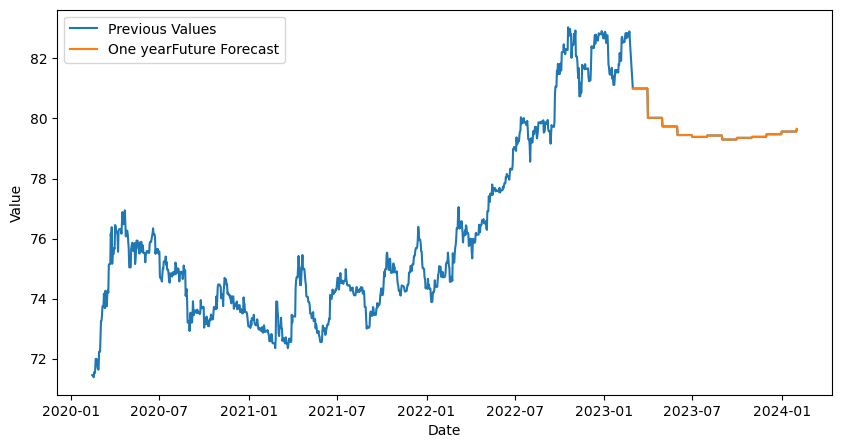

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(complete_df.index, complete_df.iloc[:, -1], label='Previous Values')
plt.plot(forecast_df.index, forecast_df.iloc[:, -1], label='One yearFuture Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()